## 📈 Moving Average Indicator Selection

The first indicator in our model will be the **Moving Average (MA)**.  
To determine which **window size** (short and long) provides the strongest predictive power, we follow the approach of *Avramov, Kaplanski, and Subrahmanyam (2018)*, who introduced the **Moving Average Distance (MAD)** — the difference between short- and long-term moving averages — and tested its ability to predict future returns using regression analysis.

We will replicate this method in the cryptocurrency market:

1. Compute the MAD for multiple (short, long) MA window pairs.  
2. Run regression tests of **future returns** on the MAD for each pair.  
3. Select the window combination that shows the highest and most consistent predictive relationship.

Once the optimal window is identified, we will **apply the same MA configuration across all coins**, based on the assumption that most crypto assets exhibit **similar short-term dynamics and behavioral patterns**.


In [1]:
import pandas as pd
import numpy as np
import os
import multiprocessing as mp
import logging
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', 700)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all columns
pd.set_option('display.float_format', '{:.5f}'.format)
WINDOW = 24

In [2]:
path = f'Data/DF_Combined_2025_1h.csv'
df = pd.read_csv(path)
df['open_time'] = pd.to_datetime(df['open_time'])
df['open_time'] = pd.to_datetime(df['open_time']).dt.tz_localize(None)
print(f'DF shape - {df.shape}')


def get_coins(df: pd.DataFrame) -> list:
    cols = df.columns.tolist()
    coins = []
    for col in cols:
        if col.endswith('_open'):
            coin = col[:-5]
            coins.append(coin)
    return coins


df.head()

DF shape - (6785, 253)


,open_time,BTCUSDT_open,BTCUSDT_high,BTCUSDT_low,BTCUSDT_close,BTCUSDT_volume,BTCUSDT_RET,AAVEUSDT_open,AAVEUSDT_high,AAVEUSDT_low,AAVEUSDT_close,AAVEUSDT_volume,AAVEUSDT_RET,ADAUSDT_open,ADAUSDT_high,ADAUSDT_low,ADAUSDT_close,ADAUSDT_volume,ADAUSDT_RET,ALGOUSDT_open,ALGOUSDT_high,ALGOUSDT_low,ALGOUSDT_close,ALGOUSDT_volume,ALGOUSDT_RET,APTUSDT_open,APTUSDT_high,APTUSDT_low,APTUSDT_close,APTUSDT_volume,APTUSDT_RET,ARBUSDT_open,ARBUSDT_high,ARBUSDT_low,ARBUSDT_close,ARBUSDT_volume,ARBUSDT_RET,ATOMUSDT_open,ATOMUSDT_high,ATOMUSDT_low,ATOMUSDT_close,ATOMUSDT_volume,ATOMUSDT_RET,AVAXUSDT_open,AVAXUSDT_high,AVAXUSDT_low,AVAXUSDT_close,AVAXUSDT_volume,AVAXUSDT_RET,BCHUSDT_open,BCHUSDT_high,BCHUSDT_low,BCHUSDT_close,BCHUSDT_volume,BCHUSDT_RET,BNBUSDT_open,BNBUSDT_high,BNBUSDT_low,BNBUSDT_close,BNBUSDT_volume,BNBUSDT_RET,DOGEUSDT_open,DOGEUSDT_high,DOGEUSDT_low,DOGEUSDT_close,DOGEUSDT_volume,DOGEUSDT_RET,DOTUSDT_open,DOTUSDT_high,DOTUSDT_low,DOTUSDT_close,DOTUSDT_volume,DOTUSDT_RET,ENAUSDT_open,ENAUSDT_high,ENAUSDT_low,ENAUSDT_close,ENAUSDT_volume,ENAUSDT_RET,ENSUSDT_open,ENSUSDT_high,ENSUSDT_low,ENSUSDT_close,ENSUSDT_volume,ENSUSDT_RET,ETCUSDT_open,ETCUSDT_high,ETCUSDT_low,ETCUSDT_close,ETCUSDT_volume,ETCUSDT_RET,ETHUSDT_open,ETHUSDT_high,ETHUSDT_low,ETHUSDT_close,ETHUSDT_volume,ETHUSDT_RET,FETUSDT_open,FETUSDT_high,FETUSDT_low,FETUSDT_close,FETUSDT_volume,FETUSDT_RET,FILUSDT_open,FILUSDT_high,FILUSDT_low,FILUSDT_close,FILUSDT_volume,FILUSDT_RET,HBARUSDT_open,HBARUSDT_high,HBARUSDT_low,HBARUSDT_close,HBARUSDT_volume,HBARUSDT_RET,ICPUSDT_open,ICPUSDT_high,ICPUSDT_low,ICPUSDT_close,ICPUSDT_volume,ICPUSDT_RET,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,LINKUSDT_open,LINKUSDT_high,LINKUSDT_low,LINKUSDT_close,LINKUSDT_volume,LINKUSDT_RET,LTCUSDT_open,LTCUSDT_high,LTCUSDT_low,LTCUSDT_close,LTCUSDT_volume,LTCUSDT_RET,NEARUSDT_open,NEARUSDT_high,NEARUSDT_low,NEARUSDT_close,NEARUSDT_volume,NEARUSDT_RET,ONDOUSDT_open,ONDOUSDT_high,ONDOUSDT_low,ONDOUSDT_close,ONDOUSDT_volume,ONDOUSDT_RET,OPUSDT_open,OPUSDT_high,OPUSDT_low,OPUSDT_close,OPUSDT_volume,OPUSDT_RET,PENGUUSDT_open,PENGUUSDT_high,PENGUUSDT_low,PENGUUSDT_close,PENGUUSDT_volume,PENGUUSDT_RET,POLUSDT_open,POLUSDT_high,POLUSDT_low,POLUSDT_close,POLUSDT_volume,POLUSDT_RET,RAYUSDT_open,RAYUSDT_high,RAYUSDT_low,RAYUSDT_close,RAYUSDT_volume,RAYUSDT_RET,RENDERUSDT_open,RENDERUSDT_high,RENDERUSDT_low,RENDERUSDT_close,RENDERUSDT_volume,RENDERUSDT_RET,SEIUSDT_open,SEIUSDT_high,SEIUSDT_low,SEIUSDT_close,SEIUSDT_volume,SEIUSDT_RET,SOLUSDT_open,SOLUSDT_high,SOLUSDT_low,SOLUSDT_close,SOLUSDT_volume,SOLUSDT_RET,SUIUSDT_open,SUIUSDT_high,SUIUSDT_low,SUIUSDT_close,SUIUSDT_volume,SUIUSDT_RET,TAOUSDT_open,TAOUSDT_high,TAOUSDT_low,TAOUSDT_close,TAOUSDT_volume,TAOUSDT_RET,TONUSDT_open,TONUSDT_high,TONUSDT_low,TONUSDT_close,TONUSDT_volume,TONUSDT_RET,TRXUSDT_open,TRXUSDT_high,TRXUSDT_low,TRXUSDT_close,TRXUSDT_volume,TRXUSDT_RET,UNIUSDT_open,UNIUSDT_high,UNIUSDT_low,UNIUSDT_close,UNIUSDT_volume,UNIUSDT_RET,VETUSDT_open,VETUSDT_high,VETUSDT_low,VETUSDT_close,VETUSDT_volume,VETUSDT_RET,WLDUSDT_open,WLDUSDT_high,WLDUSDT_low,WLDUSDT_close,WLDUSDT_volume,WLDUSDT_RET,XLMUSDT_open,XLMUSDT_high,XLMUSDT_low,XLMUSDT_close,XLMUSDT_volume,XLMUSDT_RET,XRPUSDT_open,XRPUSDT_high,XRPUSDT_low,XRPUSDT_close,XRPUSDT_volume,XRPUSDT_RET,ZECUSDT_open,ZECUSDT_high,ZECUSDT_low,ZECUSDT_close,ZECUSDT_volume,ZECUSDT_RET
0,2024-12-31 23:00:00,93469.10000,93736.90000,93356.60000,93548.90000,3036.94600,0.00085,309.59000,311.66000,307.85000,308.70000,16569.70000,-0.00287,0.84400,0.84640,0.84170,0.84470,10080834,0.00071,0.33340,0.33610,0.33290,0.33440,6425491.90000,0.00300,8.70260,8.74410,8.67540,8.71210,399404.20000,0.00105,0.72200,0.72400,0.71980,0.72180,2892544.20000,-0.00028,6.18900,6.21300,6.17600,6.18700,167108.60000,-0.00032,35.63100,35.77200,35.55400,35.68800,132257,0.00160,433.81000,435.66000,432.86000,434.36000,6274.99100,0.00127,700.84000,702.59000,699.11000,702.12000,22770.66000,0.00184,0.31593,

In [3]:
def add_ma_columns(df: pd.DataFrame, window: int = 30) -> pd.DataFrame:
    """Add moving average columns for all *_close and return the updated DataFrame."""
    close_cols = [c for c in df.columns if c.endswith('_close')]
    ma = df[close_cols].rolling(window).mean()
    ma.columns = [c.replace('_close', f'_MA{window}') for c in close_cols]
    return pd.concat([df, ma], axis=1)

def add_is_above_ma(df: pd.DataFrame, window: int = 30) -> pd.DataFrame:
    """Add *_IsAboveMA columns (True if close > MA) and return the updated DataFrame."""
    close_cols = [c for c in df.columns if c.endswith('_close')]
    ma_cols = [f"{c.replace('_close', f'_MA{window}')}" for c in close_cols]
    is_above = df[close_cols].gt(df[ma_cols].values)
    is_above.columns = [c.replace('_close', '_IsAboveMA') for c in close_cols]
    return pd.concat([df, is_above.astype('boolean')], axis=1)

def add_in_position(df: pd.DataFrame) -> pd.DataFrame:
    """Add *_InPosition columns (yesterday's IsAboveMA) and return the updated DataFrame."""
    is_above_cols = [c for c in df.columns if c.endswith('_IsAboveMA')]
    in_pos = df[is_above_cols].shift(1)
    in_pos.columns = [c.replace('_IsAboveMA', '_InPosition') for c in is_above_cols]
    return pd.concat([df, in_pos.astype('boolean')], axis=1)

In [4]:
df = add_ma_columns(df, window=WINDOW)
df = add_is_above_ma(df, window=WINDOW)
df = add_in_position(df)
df = df.dropna()
df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()

,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_MA24,JUPUSDT_IsAboveMA,JUPUSDT_InPosition
23,0.85200,0.85320,0.84740,0.85120,851912,-0.00106,0.83090,True,False
24,0.85120,0.85460,0.84750,0.85050,866206,-0.00082,0.83230,True,True
25,0.85060,0.86900,0.84720,0.86290,3107363,0.01458,0.83329,True,True
26,0.86290,0.87100,0.85650,0.86110,1497422,-0.00209,0.83457,True,True
27,0.86130,0.87450,0.85910,0.87310,1769991,0.01394,0.83623,True,True


In [5]:
def add_entry_exit_flags(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add both *_Entry and *_Exit columns:
      - Entry = 1 when prev bar was out (False) and current bar is in (True)
      - Exit  = 1 when prev bar was in (True) and current bar is out (False)
    """
    for col in df.columns:
        if col.endswith('_Entry'):
            print('Entry columns already exists.')
            return df
        
    out = df.copy()
    inpos_cols = [c for c in out.columns if c.endswith('_InPosition')]

    prev = out[inpos_cols].astype('boolean').shift(1).fillna(False)
    curr = out[inpos_cols].astype('boolean').fillna(False)

    # Entries: transition from 0 → 1
    entries = (~prev & curr).astype('int8')
    entries.columns = [c.replace('_InPosition', '_Entry') for c in inpos_cols]

    # Exits: transition from 1 → 0
    exits = (prev & ~curr).astype('int8')
    exits.columns = [c.replace('_InPosition', '_Exit') for c in inpos_cols]

    return pd.concat([out, entries, exits], axis=1)

df = add_entry_exit_flags(df)
df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()

,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_MA24,JUPUSDT_IsAboveMA,JUPUSDT_InPosition,JUPUSDT_Entry,JUPUSDT_Exit
23,0.85200,0.85320,0.84740,0.85120,851912,-0.00106,0.83090,True,False,0,0
24,0.85120,0.85460,0.84750,0.85050,866206,-0.00082,0.83230,True,True,1,0
25,0.85060,0.86900,0.84720,0.86290,3107363,0.01458,0.83329,True,True,0,0
26,0.86290,0.87100,0.85650,0.86110,1497422,-0.00209,0.83457,True,True,0,0
27,0.86130,0.87450,0.85910,0.87310,1769991,0.01394,0.83623,True,True,0,0


In [6]:
def add_ret_in_out_position(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each coin in df, add:
      - *_RET_InPosition: RET when InPosition is True, else 0
      - *_RET_OutOfPosition: RET when InPosition is False, else 0
    """
    out = df.copy()
    ret_cols = [c for c in df.columns if c.endswith('_RET')]

    for ret_col in ret_cols:
        base = ret_col.replace('_RET', '')
        pos_col = f"{base}_InPosition"
        if pos_col not in df.columns:
            continue

        out[f"{base}_RET_InPosition"] = df[ret_col].where(df[pos_col], 0)
        out[f"{base}_RET_OutOfPosition"] = df[ret_col].where(~df[pos_col], 0)

    return out

df = add_ret_in_out_position(df)
df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()

,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_MA24,JUPUSDT_IsAboveMA,JUPUSDT_InPosition,JUPUSDT_Entry,JUPUSDT_Exit,JUPUSDT_RET_InPosition,JUPUSDT_RET_OutOfPosition
23,0.85200,0.85320,0.84740,0.85120,851912,-0.00106,0.83090,True,False,0,0,0.00000,-0.00106
24,0.85120,0.85460,0.84750,0.85050,866206,-0.00082,0.83230,True,True,1,0,-0.00082,0.00000
25,0.85060,0.86900,0.84720,0.86290,3107363,0.01458,0.83329,True,True,0,0,0.01458,0.00000
26,0.86290,0.87100,0.85650,0.86110,1497422,-0.00209,0.83457,True,True,0,0,-0.00209,0.00000
27,0.86130,0.87450,0.85910,0.87310,1769991,0.01394,0.83623,True,True,0,0,0.01394,0.00000


In [7]:
def add_all_cumulative_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds cumulative return columns for each coin:
      - <COIN>_RET_CUM
      - <COIN>_RET_InPosition_CUM   (if exists)
      - <COIN>_RET_OutOfPosition_CUM (if exists)
    """
    ret_cols = [
        c for c in df.columns
        if c.endswith('_RET') and not c.endswith(('RET_InPosition', 'RET_OutOfPosition'))
    ]

    newcols = {}
    idx = df.index

    for ret_col in ret_cols:
        base = ret_col.replace('_RET', '')

        # total
        arr = (1 + df[ret_col].fillna(0)).to_numpy()
        newcols[f"{base}_RET_CUM"] = pd.Series(np.cumprod(arr) - 1, index=idx)

        # in / out (if present)
        in_col  = f"{base}_RET_InPosition"
        out_col = f"{base}_RET_OutOfPosition"

        if in_col in df.columns:
            arr_in = (1 + df[in_col].fillna(0)).to_numpy()
            newcols[f"{in_col}_CUM"] = pd.Series(np.cumprod(arr_in) - 1, index=idx)

        if out_col in df.columns:
            arr_out = (1 + df[out_col].fillna(0)).to_numpy()
            newcols[f"{out_col}_CUM"] = pd.Series(np.cumprod(arr_out) - 1, index=idx)

    # one join to avoid fragmentation
    return df.join(pd.DataFrame(newcols, index=idx))


df = add_all_cumulative_returns(df)
df[[col for col in df.columns if col.startswith('JUPUSDT')]].head()


,JUPUSDT_open,JUPUSDT_high,JUPUSDT_low,JUPUSDT_close,JUPUSDT_volume,JUPUSDT_RET,JUPUSDT_MA24,JUPUSDT_IsAboveMA,JUPUSDT_InPosition,JUPUSDT_Entry,JUPUSDT_Exit,JUPUSDT_RET_InPosition,JUPUSDT_RET_OutOfPosition,JUPUSDT_RET_CUM,JUPUSDT_RET_InPosition_CUM,JUPUSDT_RET_OutOfPosition_CUM
23,0.85200,0.85320,0.84740,0.85120,851912,-0.00106,0.83090,True,False,0,0,0.00000,-0.00106,-0.00106,0.00000,-0.00106
24,0.85120,0.85460,0.84750,0.85050,866206,-0.00082,0.83230,True,True,1,0,-0.00082,0.00000,-0.00188,-0.00082,-0.00106
25,0.85060,0.86900,0.84720,0.86290,3107363,0.01458,0.83329,True,True,0,0,0.01458,0.00000,0.01267,0.01375,-0.00106
26,0.86290,0.87100,0.85650,0.86110,1497422,-0.00209,0.83457,True,True,0,0,-0.00209,0.00000,0.01056,0.01163,-0.00106
27,0.86130,0.87450,0.85910,0.87310,1769991,0.01394,0.83623,True,True,0,0,0.01394,0.00000,0.02464,0.02573,-0.00106


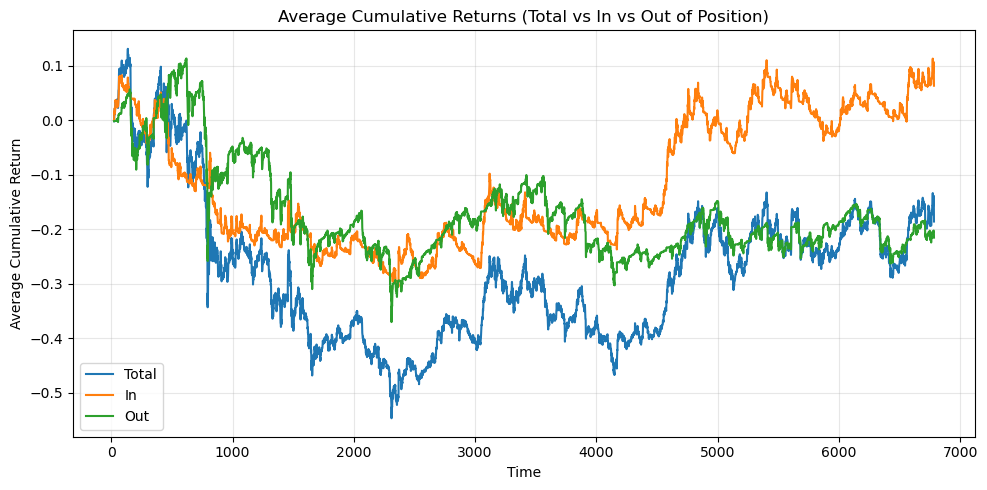

In [8]:
def plot_avg_cumulative_returns_all(df: pd.DataFrame):
    """
    Plot average cumulative returns for:
      - total  → *_RET_CUM
      - in      → *_RET_InPosition_CUM
      - out     → *_RET_OutOfPosition_CUM
    All on the same figure.
    """
    modes = {
        "total": [c for c in df.columns if c.endswith('_RET_CUM') and 'InPosition' not in c and 'OutOfPosition' not in c],
        "in":    [c for c in df.columns if c.endswith('_RET_InPosition_CUM')],
        "out":   [c for c in df.columns if c.endswith('_RET_OutOfPosition_CUM')],
    }

    plt.figure(figsize=(10, 5))

    for mode, cols in modes.items():
        if not cols:
            continue

        avg_cum = df[cols].mean(axis=1)
        plt.plot(df.index, avg_cum, label=mode.capitalize())

    plt.title("Average Cumulative Returns (Total vs In vs Out of Position)")
    plt.xlabel("Time")
    plt.ylabel("Average Cumulative Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_avg_cumulative_returns_all(df)

